In [1]:
import pyspark
import pandas as pd

In [2]:
sc = pyspark.SparkContext(appName="teste")

In [3]:
sc

<SparkContext master=local[*] appName=teste>

In [4]:
sc.parallelize(range(1000)).count()

1000

In [5]:
rdd = sc.sequenceFile("web_brasil_small/part-00000") #rdd = sc.textFile("web_brasil_small/part-00000")

In [6]:
rdd.count()

36133

In [7]:
rdd.filter(lambda x: "fiscal" in x[1]).count()

1162

In [8]:
rdd.take(1)

[('https://sebodomessias.com.br/suas_compras.aspx?retirar=0&action=1&idItem=2023136',
  'Sebo do Messias - Suas Compras\nLivroDVDCDLPGibiRevista\n|\nBusca avancada\nBem-vindo ao\nSebo do Messias.\nFaça o seu LOGIN\nMinha conta\nAlterar senha\nAlterar Email\nMeu Carrinho\nHistórico de Pedidos\nMeus Interesses\nSair\n1\nNão possui conta?\nCadastre-se\nOlá, seja bem-vindo!\n×\nPara prosseguir, por favor identifique-se utilizando os campos abaixo e depois clique no botão “ENTRAR”.\nE-mail\nSenha\nEsqueci minha senha\nEsqueceu sua senha?\n×\nPreencha o seu email no campo abaixo e clique no botão "ENVIAR".\nE-mail\nFaça seu login\nConfirmado!\n×\nEnviamos uma mensagem em seu e-mail para alteração de senha.\n(se não encontra-lo, verifique sua caixa de spam).\nFaça seu login\nNão possui conta?\nCadastre-se\nBusca Avançada\n×\nIndique as opções relevantes a sua busca.\nBusca por: LivroDVDCDLPGibiRevista\nÁlbum:\nArtista / Banda:\nAno:\nGravadora: Selecione uma Gravadora32 Blues4adABKCOABRIL MUS

In [32]:
import math


def conta_palavras_em_doc(item):
    url, text = item
    words = text.strip().split()
    return [(word.lower(), 1) for word in set(words)] # set() -> contagem de documentos que a palavra aparece

def junta_contagens(nova_contagem, contagem_atual):
    return nova_contagem + contagem_atual

def computa_relevancia(item):
    palavra, valor = item
    freq, idf = valor
    relevancia = freq*idf
    return (palavra, relevancia)
    
def conta_palavras_total(item):
    url, text = item
    words = text.strip().split()
    words = [w for w in words if w.isalpha()]
    words_filtered = [w.lower() for w in words if len(w) > 3]
    return [(word.lower(), 1) for word in words_filtered]

def filtra_doc_freq(item):
    palavra, contagem = item
    return (contagem < DOC_COUNT_MAX) and (contagem >= DOC_COUNT_MIN)

def sort_100(item):
    palavra, relevancia = item
    return 

def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(N / contagem)
    return(palavra, idf)

def computa_freq(item):
    palavra, contagem = item
    freq = math.log10(1+contagem)
    return(palavra, freq)

def encontra_palavra(item, palavra):
    url, text = item
    words = text.strip().split()
    words_list = [word.lower() for word in words]
    if palavra in words_list:
        return [item]
    return []

def encontra_palavra1(item):
    return encontra_palavra(item, palavra1)

def encontra_palavra2(item):
    return encontra_palavra(item, palavra2)

def conta_palavras_local(item):
    url, text = item
    words = text.strip().split()
    words = [w for w in words if w.isalpha()]
    filtered_words = []
    for i in range(len(words)):
        if i < 5:
            if palavra1 in words[: i + 5] or palavra2 in words[: i + 5]:
                filtered_words.append(words[i])
        elif i > len(words) - 5:
            if palavra1 in words[i - 5 :] or palavra2 in words[i - 5 :]:
                filtered_words.append(words[i])
        else:
            if (palavra1 in words[i - 5 : i + 5] or palavra2 in words[i - 5 : i + 5]):
                filtered_words.append(words[i])

    filtered_words = [w.lower() for w in filtered_words if len(w) > 3]
    return [(w.lower(), 1) for w in filtered_words]

In [10]:
url, text = rdd.take(1)[0]
url

'https://sebodomessias.com.br/suas_compras.aspx?retirar=0&action=1&idItem=2023136'

In [11]:
rdd_word_freq = rdd.flatMap(conta_palavras_total).reduceByKey(junta_contagens)

In [12]:
rdd_word_freq.take(10)

[('login', 11306),
 ('senha', 8876),
 ('esqueci', 1585),
 ('musicatração', 4),
 ('nostracastlecastle', 4),
 ('musiccaytronicscbscd', 4),
 ('recordschina', 4),
 ('starcmc', 4),
 ('musicdccdead', 4),
 ('recordsdebut', 4)]

# Início do estudo

In [13]:
N = rdd.count()

DOC_COUNT_MIN = 10
DOC_COUNT_MAX = N * 0.7

palavra1 = 'boulos'
palavra2 = 'covas'

In [14]:
rdd_palavra1 = rdd.flatMap(encontra_palavra1)
rdd_palavra2 = rdd.flatMap(encontra_palavra2)

In [15]:
rdd_palavra1.count()

79

In [16]:
rdd_palavra2.count()

125

In [17]:
rdd_palavra_intersection = rdd_palavra1.intersection(rdd_palavra2)
rdd_palavra_intersection.count()

15

# IDF

In [18]:
rdd_doc_count_intersection = rdd.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)

rdd_idf = rdd.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_idf = rdd_idf.map(computa_idf)

In [19]:
rdd_idf.take(10)

[('login', 0.5045950399334663),
 ('senha', 0.6096867274975956),
 ('esqueci', 1.357874754503796),
 ('musicatração', 3.955844029729604),
 ('nostracastlecastle', 3.955844029729604),
 ('musiccaytronicscbscd', 3.955844029729604),
 ('recordschina', 3.955844029729604),
 ('starcmc', 3.955844029729604),
 ('musicdccdead', 3.955844029729604),
 ('recordsdebut', 3.955844029729604)]

# COMPUTA FREQ

In [20]:
rdd_words_count = rdd_palavra_intersection.flatMap(conta_palavras_total).reduceByKey(junta_contagens)

rdd_words_freq = rdd_words_count.map(computa_freq)

In [21]:
rdd_words_freq.take(10)

[('culturais', 0.47712125471966244),
 ('eleições', 1.6532125137753437),
 ('cargos', 0.6020599913279624),
 ('celso', 1.1139433523068367),
 ('helou', 0.3010299956639812),
 ('vereadores', 0.6020599913279624),
 ('mesmo', 1.3222192947339193),
 ('conhecimentos', 0.3010299956639812),
 ('tornarem', 0.6020599913279624),
 ('promoveu', 0.3010299956639812)]

# TABELA 1

In [22]:
rdd_join = rdd_words_freq.join(rdd_idf)
rdd_relevancia = rdd_join.map(computa_relevancia)

list_relevance = rdd_relevancia.takeOrdered(100, key=lambda x: -x[1])
#list_relevance = sorted(list_relevance, key=lambda x: -x[1])[:100]
list_relevance

[('ribalta', 4.251571469916075),
 ('goldman', 3.99251011640805),
 ('blogue', 3.77325067423827),
 ('boulos', 3.532480230841651),
 ('lobão', 3.51350349409971),
 ('commodities', 3.495520445363298),
 ('franklim', 3.487578915400842),
 ('noleto', 3.4651948159585624),
 ('russomanno', 3.4056801872661016),
 ('lobao', 3.3195451504692186),
 ('sttr', 3.3195451504692186),
 ('cutrim', 3.280697028808945),
 ('mohamed', 3.2356617950391575),
 ('esmael', 3.2236373293806038),
 ('jurivê', 3.1942616582349888),
 ('krikati', 3.175199104364647),
 ('brejão', 3.151696965500766),
 ('fiquene', 3.1376850575329107),
 ('heluy', 3.1376850575329107),
 ('edjailson', 3.1376850575329107),
 ('covas', 3.1244285144047907),
 ('timbira', 3.0683489831615134),
 ('frazão', 3.067026596053407),
 ('imperatriz', 3.0596675979396064),
 ('armazéns', 3.045395489386108),
 ('megabancos', 3.0028343302598484),
 ('raimundo', 2.9983802384876865),
 ('clodomir', 2.939861798913858),
 ('ribamar', 2.911303674721313),
 ('waquim', 2.8579633368629933)

# TABELA 2a

In [23]:
#rdd_doc_count_palavra1 = rdd_palavra1.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)
#rdd_idf_palavra1 = rdd_doc_count_palavra1.map(computa_idf)

rdd_words_count_palavra1 = rdd_palavra1.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_words_freq_palavra1 = rdd_words_count_palavra1.map(computa_freq)

rdd_join_palavra1 = rdd_words_freq_palavra1.join(rdd_idf)
rdd_relevancia_palavra1 = rdd_join_palavra1.map(computa_relevancia)

list_relevance_palavra1 = rdd_relevancia_palavra1.takeOrdered(100, key=lambda x: -x[1])
#list_relevance_palavra1 = sorted(list_relevance_palavra1, key=lambda x: -x[1])[:100]
list_relevance_palavra1

[('boulos', 5.10647349388973),
 ('slavoj', 4.93087237745187),
 ('hoppe', 4.908471749008466),
 ('boitempo', 4.865192595366118),
 ('žižek', 4.852744840199639),
 ('libertários', 4.835820552549111),
 ('buonicore', 4.798396798445808),
 ('zigoto', 4.7897628627246),
 ('libertarianismo', 4.776973246583331),
 ('belluzzo', 4.7381035622372245),
 ('ubes', 4.710545141818972),
 ('conservadores', 4.708670559530754),
 ('grabois', 4.672637379626482),
 ('jabbour', 4.652881161356129),
 ('zizek', 4.634906240806863),
 ('libertário', 4.577026253270516),
 ('occupy', 4.433855350784556),
 ('bertolino', 4.430795153285126),
 ('bellani', 4.40162266775432),
 ('quartim', 4.366140041949816),
 ('venício', 4.339075663445367),
 ('gramacho', 4.306937831899488),
 ('zahluth', 4.306301676893127),
 ('bhadrakumar', 4.306301676893127),
 ('conservador', 4.296230598605244),
 ('pcdob', 4.274500649557027),
 ('stiglitz', 4.2724522119495),
 ('libertária', 4.26268562054828),
 ('ribalta', 4.251571469916075),
 ('capitalismo', 4.246670

# TABELA 2b

In [24]:
#rdd_doc_count_palavra2 = rdd_palavra2.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)
#rdd_idf_palavra2 = rdd_doc_count_palavra2.map(computa_idf)


rdd_words_count_palavra2 = rdd_palavra2.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_words_freq_palavra2 = rdd_words_count_palavra2.map(computa_freq)

rdd_join_palavra2 = rdd_words_freq_palavra2.join(rdd_idf)
rdd_relevancia_palavra2 = rdd_join_palavra2.map(computa_relevancia)

list_relevance_palavra2 = rdd_relevancia_palavra2.takeOrdered(100, key=lambda x: -x[1])
#list_relevance_palavra2 = sorted(list_relevance_palavra2, key=lambda x: -x[1])[:100]
list_relevance_palavra2

[('covas', 5.1971981846962425),
 ('circunscrição', 5.033730516936581),
 ('rjanrio', 4.925592021434108),
 ('viomundo', 4.85010268871849),
 ('geográfico', 4.821893046769834),
 ('dibrarq', 4.767137534129315),
 ('moços', 4.624993073078647),
 ('homogenea', 4.610949980229255),
 ('forth', 4.454715294644524),
 ('pretoria', 4.399044978056183),
 ('eulálio', 4.378610447193646),
 ('tomazela', 4.361417853298619),
 ('mensalão', 4.360142585641708),
 ('rupp', 4.3523220799854485),
 ('sepultado', 4.338392680114583),
 ('mayara', 4.3244802746760245),
 ('nordestinos', 4.316880671323397),
 ('hermenito', 4.306301676893127),
 ('guisard', 4.306301676893127),
 ('koellreutter', 4.306301676893127),
 ('monástico', 4.306301676893127),
 ('mayomel', 4.306301676893127),
 ('schmöckel', 4.306301676893127),
 ('sufrutoverdeus', 4.306301676893127),
 ('sindicomerciários', 4.306301676893127),
 ('capatazias', 4.306301676893127),
 ('carangolense', 4.306301676893127),
 ('comunità', 4.306301676893127),
 ('iniguaçu', 4.3063016768

In [25]:
df_palavra1 = pd.DataFrame(list_relevance_palavra1, columns =['Palavra', 'Relevância']) 
df_palavra2 = pd.DataFrame(list_relevance_palavra2, columns =['Palavra', 'Relevância']) 
df_palavra_intersect = pd.DataFrame(list_relevance, columns =['Palavra', 'Relevância']) 

In [26]:
#df_palavra1.to_csv("ResultadoPalavra1.csv")
#df_palavra2.to_csv("ResultadoPalavra2.csv")
#df_palavra_intersect.to_csv("ResultadoIntersect.csv")

In [27]:
def Convert(tup):
    di = {}
    for a, b in tup: 
        di[a] = b 
    return di 

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance_palavra1))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Boulos")

<Figure size 5000x5000 with 1 Axes>

Boulos


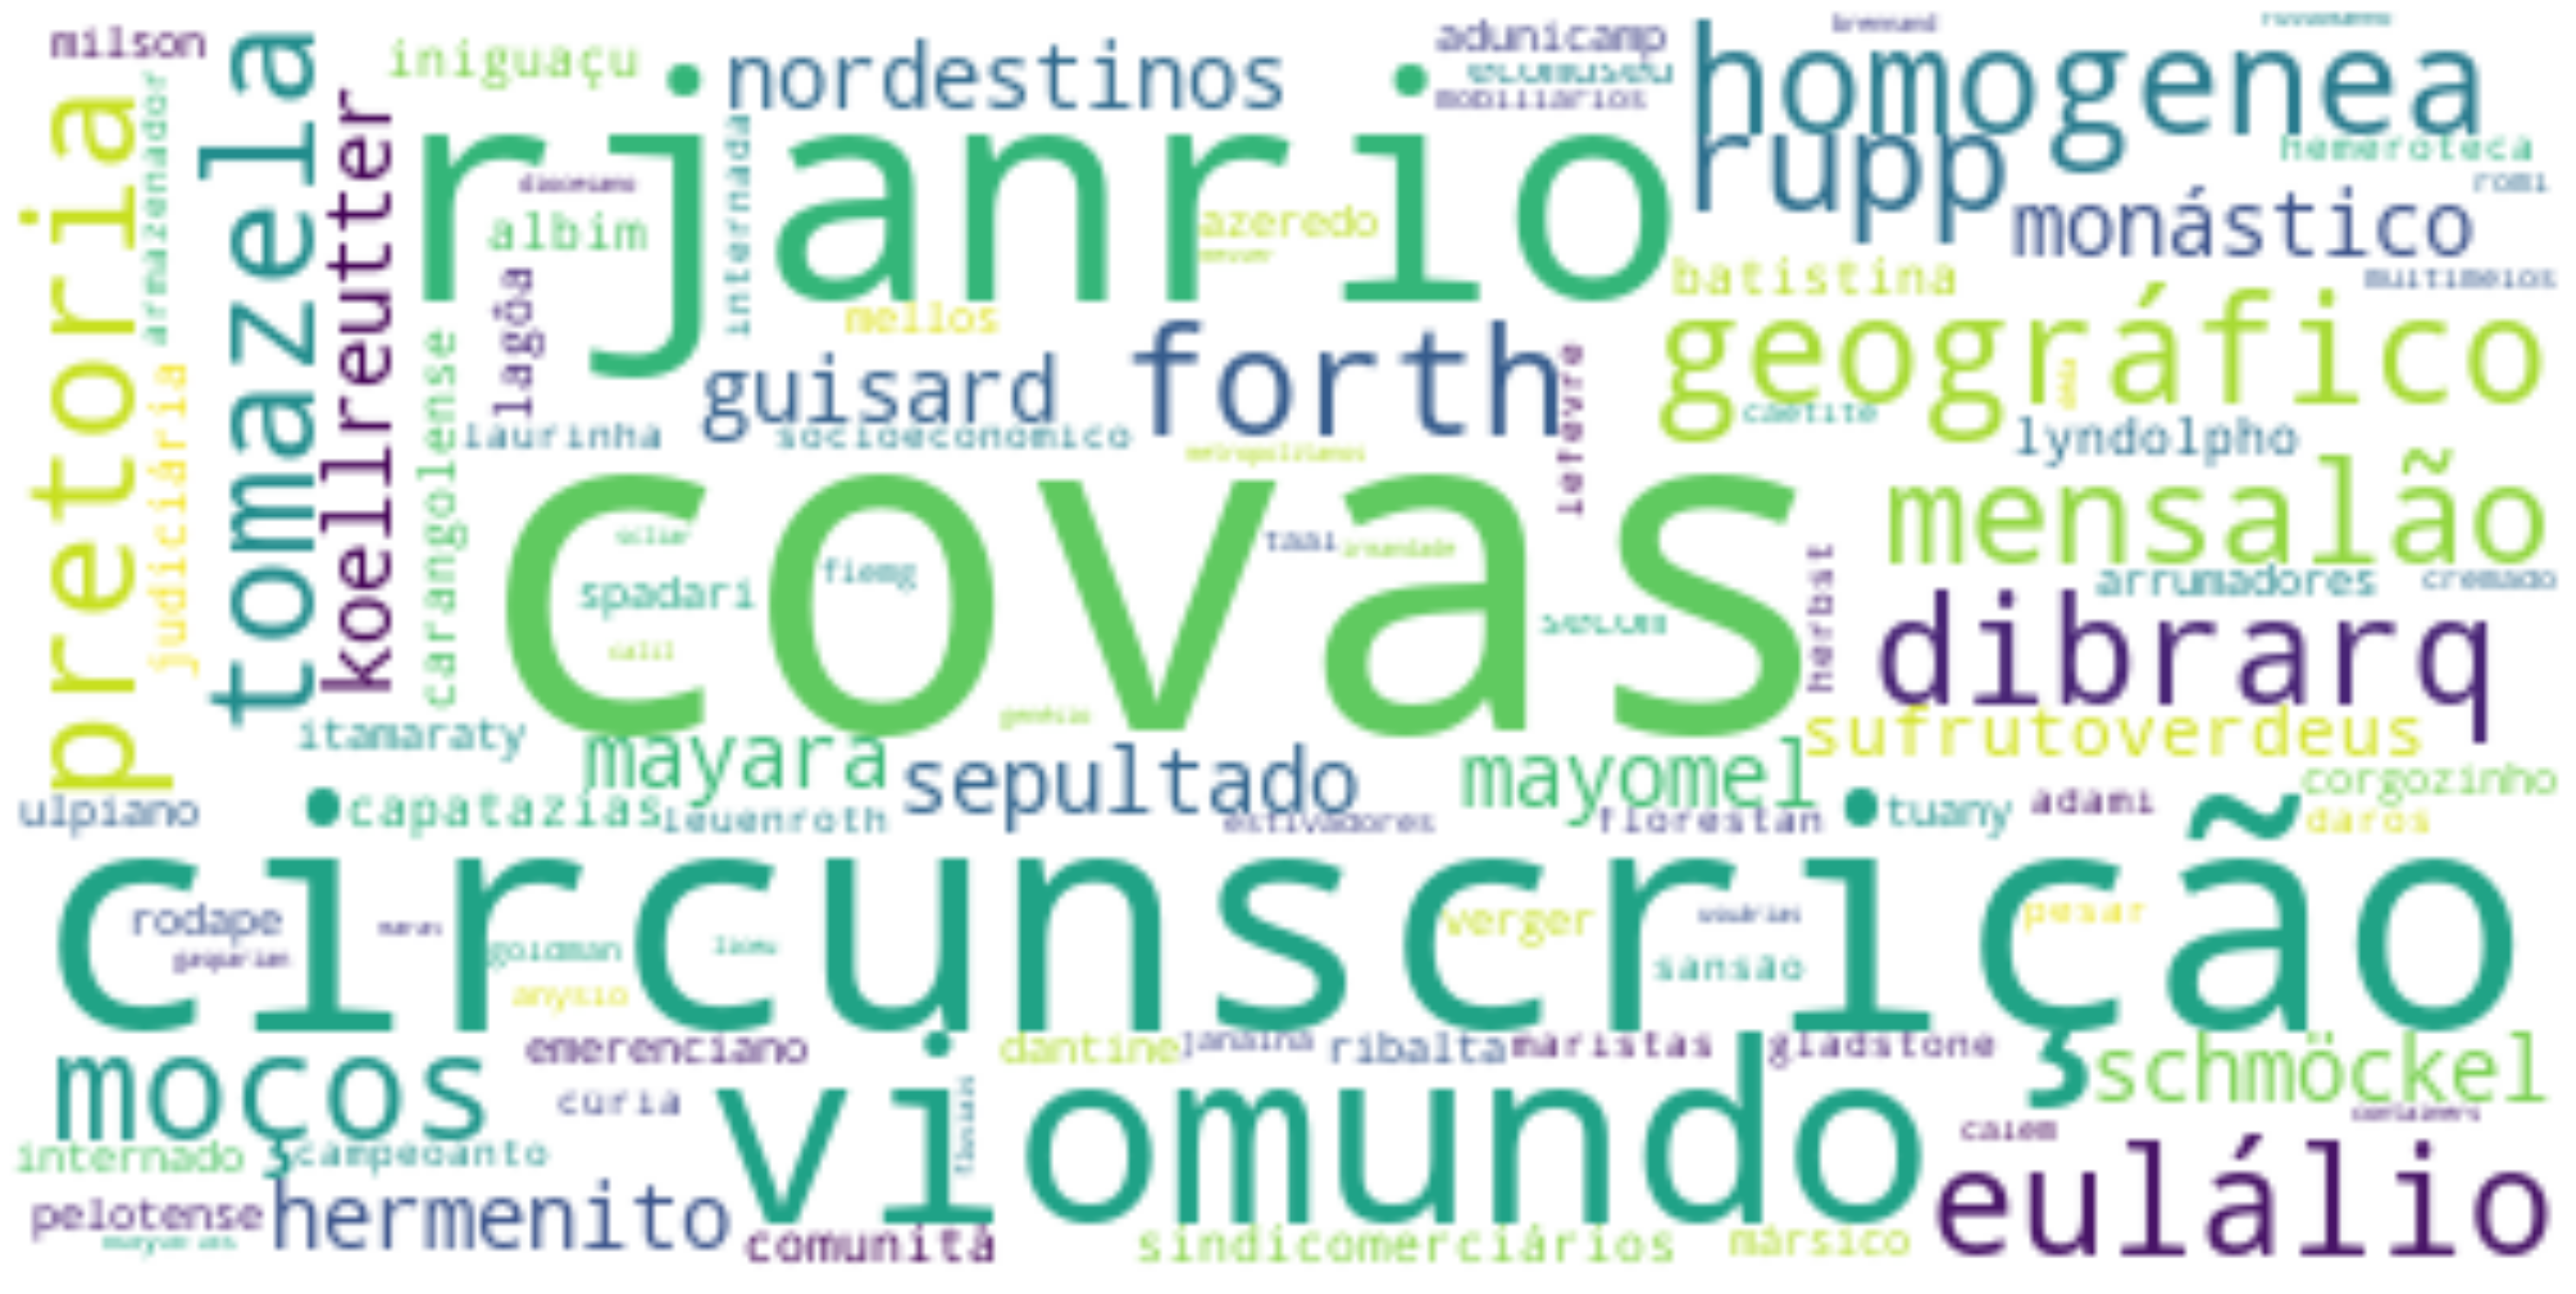

Covas


In [29]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance_palavra2))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Covas")

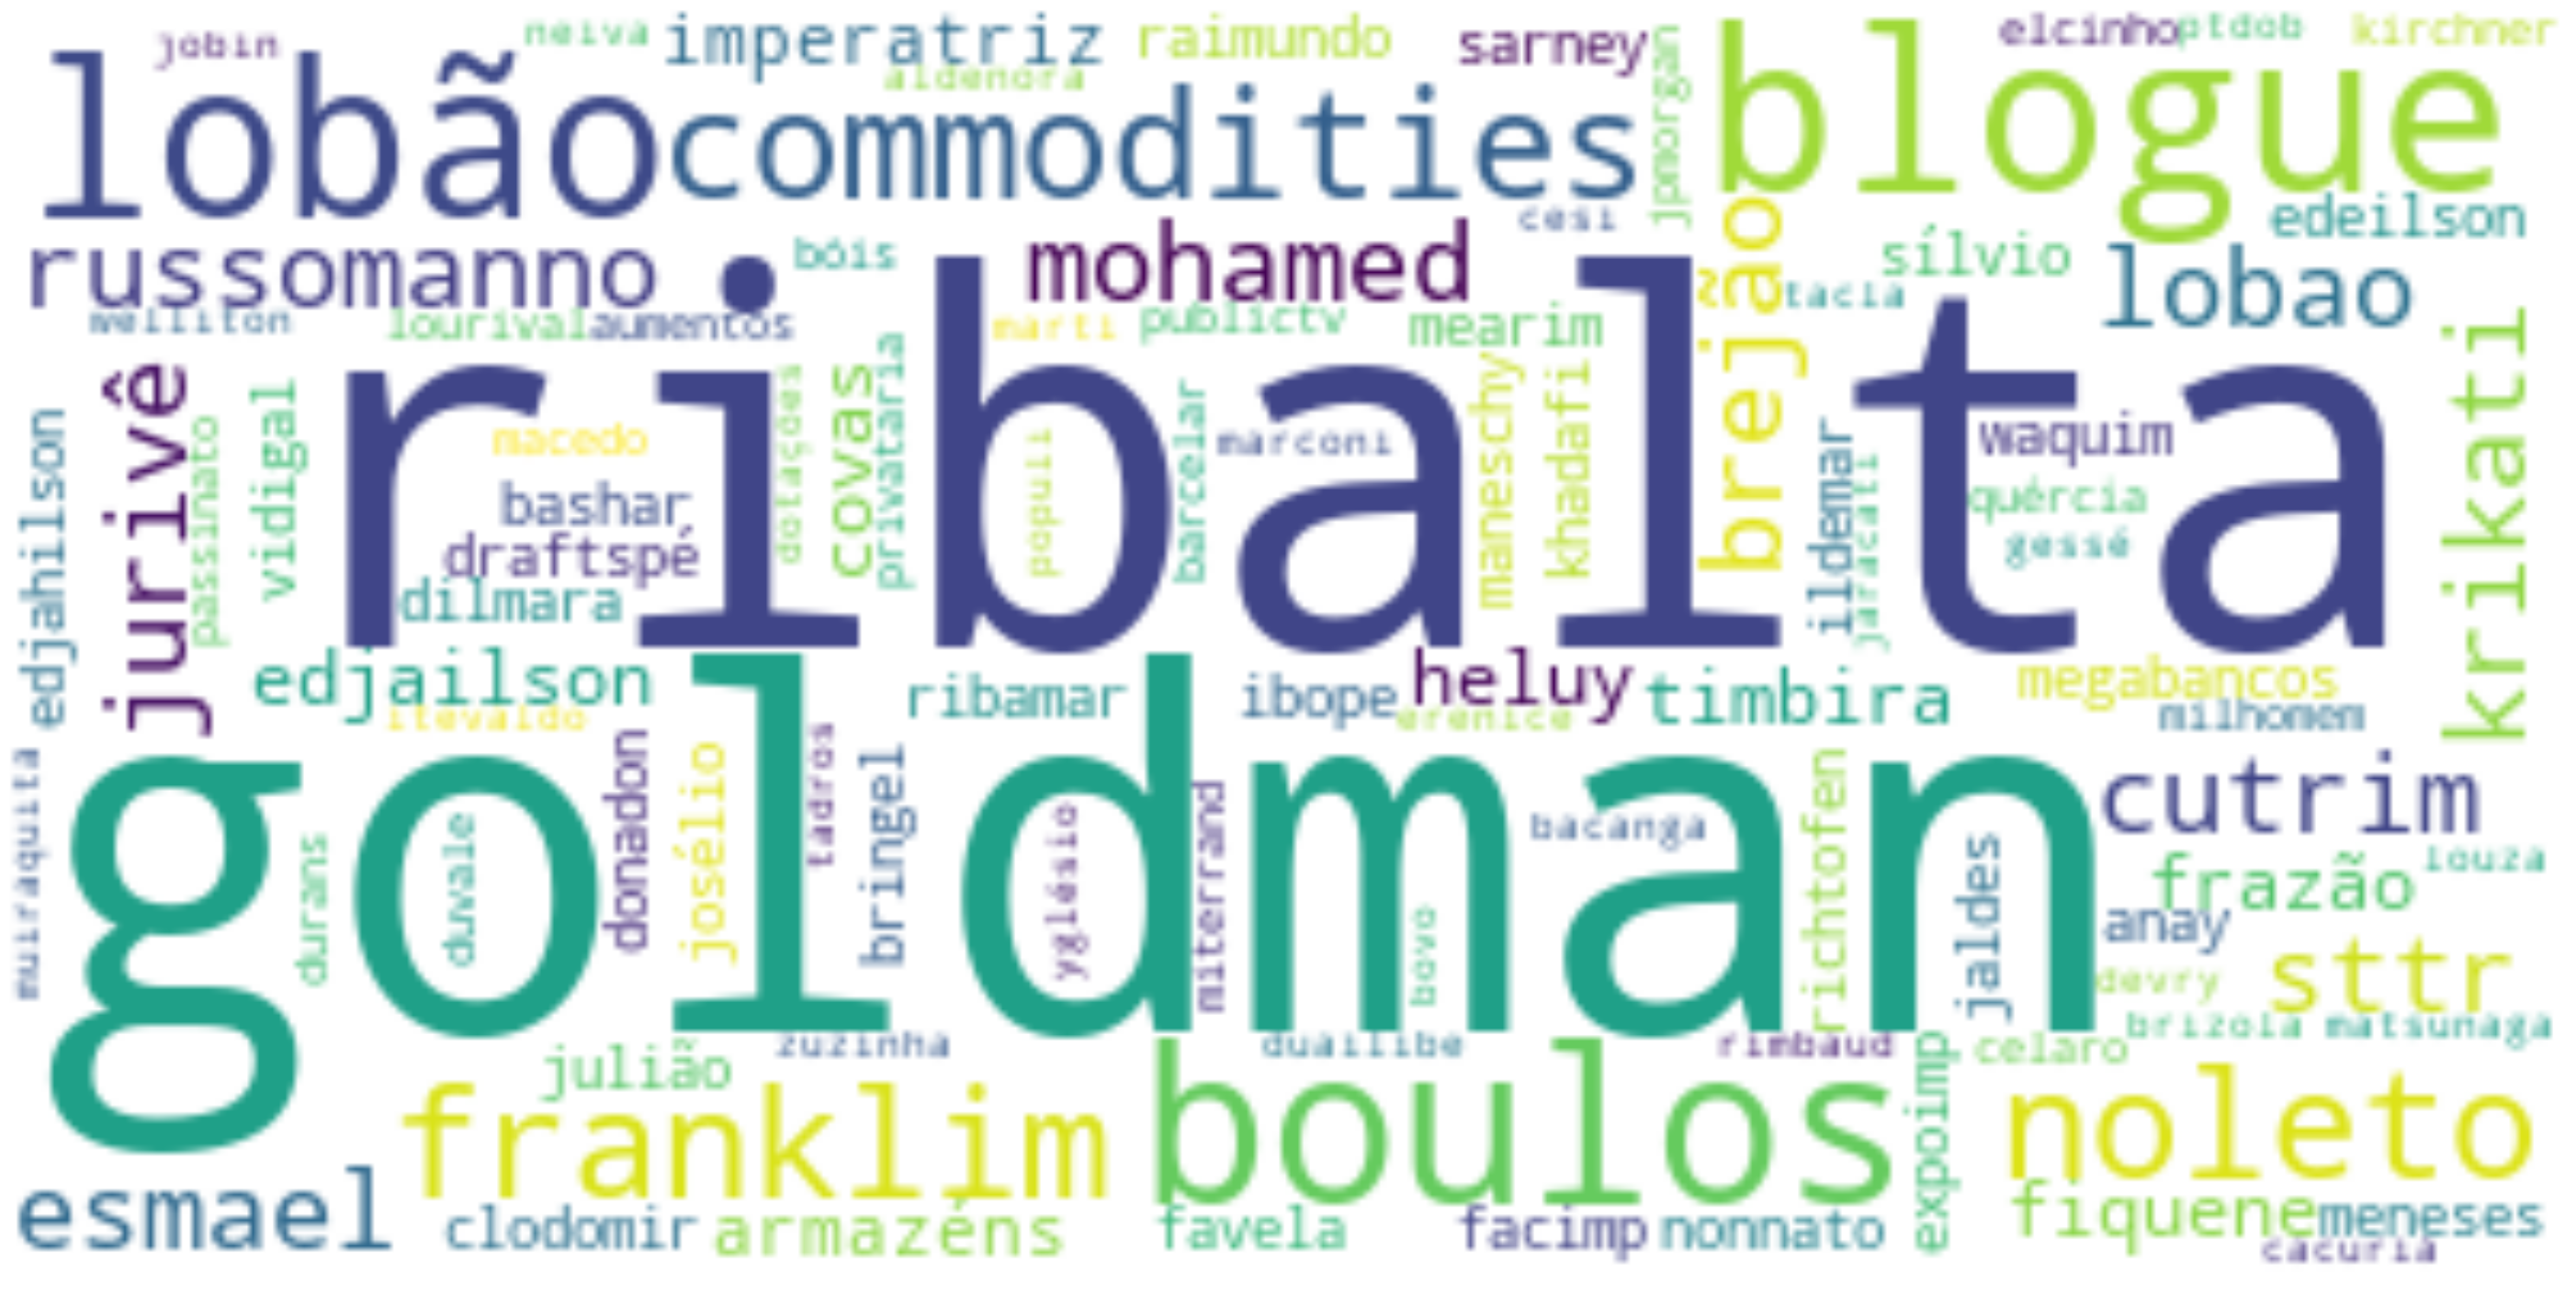

Inter


In [30]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Inter")

# Palavras locais

In [33]:
#Interseção
rdd_words_count_local = rdd_palavra_intersection.flatMap(conta_palavras_local).reduceByKey(junta_contagens)
rdd_words_freq_local = rdd_words_count_local.map(computa_freq)

rdd_join_local = rdd_words_freq_local.join(rdd_idf)
rdd_relevancia_local = rdd_join_local.map(computa_relevancia)
list_relevance_local = rdd_relevancia_local.takeOrdered(100, key=lambda x: -x[1])

#Palavra 1
rdd_words_count_palavra1_local = rdd_palavra1.flatMap(conta_palavras_local).reduceByKey(junta_contagens)
rdd_words_freq_palavra1_local = rdd_words_count_palavra1_local.map(computa_freq)

rdd_join_palavra1_local = rdd_words_freq_palavra1_local.join(rdd_idf)
rdd_relevancia_palavra1_local = rdd_join_palavra1_local.map(computa_relevancia)
list_relevance_palavra1_local = rdd_relevancia_palavra1_local.takeOrdered(100, key=lambda x: -x[1])

#Palavra 2
rdd_words_count_palavra2_local = rdd_palavra2.flatMap(conta_palavras_local).reduceByKey(junta_contagens)
rdd_words_freq_palavra2_local = rdd_words_count_palavra2_local.map(computa_freq)

rdd_join_palavra2_local = rdd_words_freq_palavra2_local.join(rdd_idf)
rdd_relevancia_palavra2_local = rdd_join_palavra2_local.map(computa_relevancia)
list_relevance_palavra2_local = rdd_relevancia_palavra2_local.takeOrdered(100, key=lambda x: -x[1])

In [34]:
list_relevance_palavra2_local

[('covas', 1.6268213011147243),
 ('canteiros', 1.4699069389938533),
 ('auxilioaluguel', 1.3720658276958015),
 ('cracolandia', 1.3720658276958015),
 ('preparação', 0.7958584350057505),
 ('suspensao', 0.6840445208754109),
 ('doria', 0.5823891051817799),
 ('morar', 0.517676707631521),
 ('bruno', 0.34772786118550414),
 ('junto', 0.3372952530140744),
 ('antes', 0.32264566866273053),
 ('ideal', 0.31268965720076125),
 ('hospital', 0.2879667119633017),
 ('tags', 0.25404214940586695),
 ('casos', 0.2522859348139046),
 ('conteúdo', 0.10523110873399823),
 ('brasil', -0.06030080579813058),
 ('para', -0.49845354993355384)]

In [35]:
list_relevance_local

[]

In [36]:
list_relevance_palavra1_local

[('boulos', 1.813209407167021),
 ('voorwald', 1.3720658276958015),
 ('meireles', 1.130960254368027),
 ('haddad', 0.9976779111681202),
 ('grêmios', 0.9411823999774418),
 ('guilherme', 0.9289012379639392),
 ('igor', 0.9110840340301796),
 ('herman', 0.8041755328769886),
 ('humor', 0.6842168709224883),
 ('henrique', 0.5556097650352158),
 ('colônia', 0.4846523932001093),
 ('fernando', 0.4276345300964425),
 ('neto', 0.39626310469722914),
 ('barbosa', 0.3818008795756233),
 ('brasileiros', 0.35081521870362725),
 ('bolsonaro', 0.2960706639491041),
 ('brasília', 0.277524944226101),
 ('silva', 0.2171790859795459),
 ('história', 0.21669353919646828),
 ('facebook', 0.13224195551049828),
 ('educação', 0.08989381959446903),
 ('brasil', -0.06030080579813058)]